# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

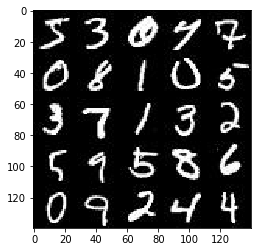

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

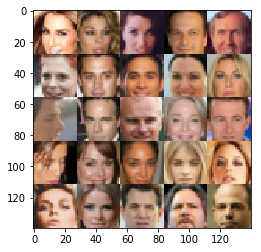

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/two/anaconda/envs/tflearn/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [97]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [99]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    # Input images is 28x28
    with tf.variable_scope('discriminator', reuse=reuse):
        # 14x14x64 filters, skip batch normalization on first layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        # 7x7x128 filters
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # 4x4x256 filters
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # Flatten image
        flat_image = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat_image, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [105]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # 7x7x512
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # 14x14x256
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 14x14x128
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 28x28x3
        logits = tf.tanh(tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same'))
        
        return logits
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [119]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_model = generator(input_z, out_channel_dim)

    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True)

    discriminator_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_model_real)))
    discriminator_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_model_fake)))
    
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_model_fake)))

    discriminator_loss = discriminator_loss_real + discriminator_loss_fake

    return discriminator_loss, generator_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [110]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [111]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [121]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    # Build Model
    width = data_shape[1]
    height = data_shape[2]
    channels = data_shape[3]
    
    images, dimensions, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(images, dimensions, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Train Model
                steps += 1
                
                batch_images *= 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={images: batch_images, dimensions: batch_z})
                _ = sess.run(g_opt, feed_dict={images: batch_images, dimensions: batch_z})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({images: batch_images, dimensions: batch_z})
                    train_loss_g = g_loss.eval({dimensions: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 10, dimensions, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0831... Generator Loss: 15.7867
Epoch 1/2... Discriminator Loss: 2.5631... Generator Loss: 0.9506
Epoch 1/2... Discriminator Loss: 0.5400... Generator Loss: 6.6571
Epoch 1/2... Discriminator Loss: 3.1692... Generator Loss: 6.5359
Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 0.7307
Epoch 1/2... Discriminator Loss: 0.8598... Generator Loss: 0.8920
Epoch 1/2... Discriminator Loss: 1.2983... Generator Loss: 0.6074
Epoch 1/2... Discriminator Loss: 1.1254... Generator Loss: 0.6651
Epoch 1/2... Discriminator Loss: 1.1209... Generator Loss: 0.7408
Epoch 1/2... Discriminator Loss: 1.1845... Generator Loss: 1.1544


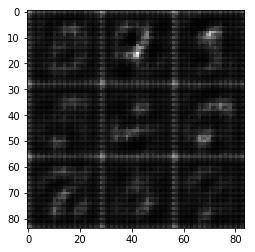

Epoch 1/2... Discriminator Loss: 1.2614... Generator Loss: 0.6707
Epoch 1/2... Discriminator Loss: 1.4500... Generator Loss: 0.7336
Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 1.1336
Epoch 1/2... Discriminator Loss: 1.3850... Generator Loss: 0.5743
Epoch 1/2... Discriminator Loss: 1.3365... Generator Loss: 0.5457
Epoch 1/2... Discriminator Loss: 1.1743... Generator Loss: 1.1915
Epoch 1/2... Discriminator Loss: 1.3315... Generator Loss: 0.8651
Epoch 1/2... Discriminator Loss: 1.3081... Generator Loss: 0.5627
Epoch 1/2... Discriminator Loss: 1.2102... Generator Loss: 0.8193
Epoch 1/2... Discriminator Loss: 1.1225... Generator Loss: 1.0187


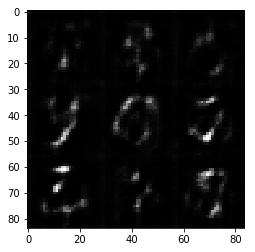

Epoch 1/2... Discriminator Loss: 1.1813... Generator Loss: 0.8444
Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 0.8803
Epoch 1/2... Discriminator Loss: 1.1371... Generator Loss: 0.7708
Epoch 1/2... Discriminator Loss: 1.3147... Generator Loss: 0.4888
Epoch 1/2... Discriminator Loss: 1.1811... Generator Loss: 0.8355
Epoch 1/2... Discriminator Loss: 1.1762... Generator Loss: 1.2927
Epoch 1/2... Discriminator Loss: 1.2440... Generator Loss: 1.0573
Epoch 1/2... Discriminator Loss: 1.3973... Generator Loss: 0.4318
Epoch 1/2... Discriminator Loss: 1.2658... Generator Loss: 0.6899
Epoch 1/2... Discriminator Loss: 0.9769... Generator Loss: 1.0948


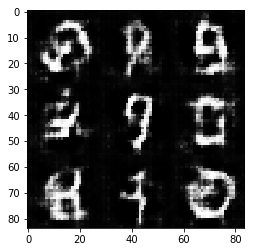

Epoch 1/2... Discriminator Loss: 1.1933... Generator Loss: 1.4633
Epoch 1/2... Discriminator Loss: 1.1986... Generator Loss: 0.9608
Epoch 1/2... Discriminator Loss: 1.1475... Generator Loss: 0.8350
Epoch 1/2... Discriminator Loss: 1.0895... Generator Loss: 0.8649
Epoch 1/2... Discriminator Loss: 1.2627... Generator Loss: 0.5861
Epoch 1/2... Discriminator Loss: 1.1443... Generator Loss: 0.6295
Epoch 1/2... Discriminator Loss: 0.9959... Generator Loss: 1.1526
Epoch 1/2... Discriminator Loss: 0.9807... Generator Loss: 0.9191
Epoch 1/2... Discriminator Loss: 1.1311... Generator Loss: 0.6800
Epoch 1/2... Discriminator Loss: 1.3688... Generator Loss: 0.8971


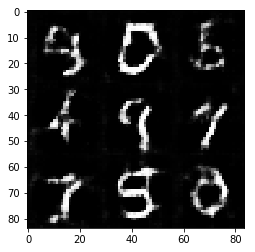

Epoch 1/2... Discriminator Loss: 1.1550... Generator Loss: 0.6363
Epoch 1/2... Discriminator Loss: 1.1500... Generator Loss: 0.6899
Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 0.5384
Epoch 1/2... Discriminator Loss: 1.1539... Generator Loss: 0.6257
Epoch 1/2... Discriminator Loss: 0.8906... Generator Loss: 1.0217
Epoch 1/2... Discriminator Loss: 1.0874... Generator Loss: 0.8631
Epoch 1/2... Discriminator Loss: 1.1731... Generator Loss: 1.1970
Epoch 1/2... Discriminator Loss: 0.9268... Generator Loss: 0.8853
Epoch 1/2... Discriminator Loss: 1.0700... Generator Loss: 1.1491
Epoch 1/2... Discriminator Loss: 0.9752... Generator Loss: 0.7917


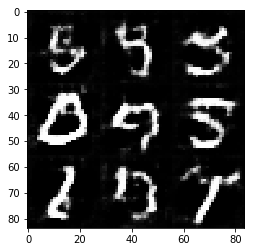

Epoch 1/2... Discriminator Loss: 1.4827... Generator Loss: 1.9186
Epoch 1/2... Discriminator Loss: 1.4876... Generator Loss: 0.4166
Epoch 1/2... Discriminator Loss: 0.9977... Generator Loss: 1.0816
Epoch 1/2... Discriminator Loss: 1.1800... Generator Loss: 0.8908
Epoch 1/2... Discriminator Loss: 1.0110... Generator Loss: 1.2106
Epoch 1/2... Discriminator Loss: 1.2919... Generator Loss: 0.5335
Epoch 1/2... Discriminator Loss: 1.4401... Generator Loss: 0.4052
Epoch 1/2... Discriminator Loss: 1.1192... Generator Loss: 0.9463
Epoch 1/2... Discriminator Loss: 0.9740... Generator Loss: 0.9647
Epoch 1/2... Discriminator Loss: 1.0267... Generator Loss: 1.1017


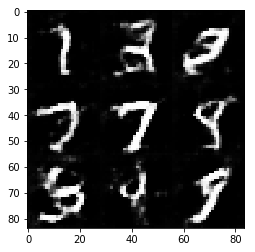

Epoch 1/2... Discriminator Loss: 1.0740... Generator Loss: 1.2668
Epoch 1/2... Discriminator Loss: 1.0961... Generator Loss: 1.3048
Epoch 1/2... Discriminator Loss: 1.3674... Generator Loss: 0.4339
Epoch 1/2... Discriminator Loss: 0.9859... Generator Loss: 0.9842
Epoch 1/2... Discriminator Loss: 1.0455... Generator Loss: 0.7844
Epoch 1/2... Discriminator Loss: 1.7393... Generator Loss: 0.2858
Epoch 1/2... Discriminator Loss: 1.0757... Generator Loss: 0.8309
Epoch 1/2... Discriminator Loss: 1.2897... Generator Loss: 0.5421
Epoch 1/2... Discriminator Loss: 0.9981... Generator Loss: 0.7801
Epoch 1/2... Discriminator Loss: 1.2249... Generator Loss: 1.5045


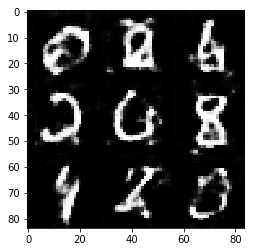

Epoch 1/2... Discriminator Loss: 0.9977... Generator Loss: 1.0166
Epoch 1/2... Discriminator Loss: 1.1510... Generator Loss: 0.6817
Epoch 1/2... Discriminator Loss: 0.8763... Generator Loss: 0.9359
Epoch 1/2... Discriminator Loss: 0.9798... Generator Loss: 1.7719
Epoch 1/2... Discriminator Loss: 1.0137... Generator Loss: 0.9095
Epoch 1/2... Discriminator Loss: 1.0468... Generator Loss: 0.7379
Epoch 1/2... Discriminator Loss: 1.5950... Generator Loss: 0.4516
Epoch 1/2... Discriminator Loss: 1.2414... Generator Loss: 0.6574
Epoch 1/2... Discriminator Loss: 1.0502... Generator Loss: 0.8372
Epoch 1/2... Discriminator Loss: 1.0458... Generator Loss: 0.8095


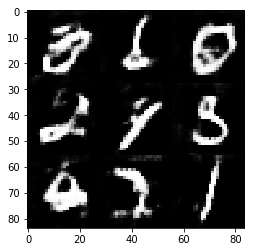

Epoch 1/2... Discriminator Loss: 1.2443... Generator Loss: 0.5305
Epoch 1/2... Discriminator Loss: 1.0591... Generator Loss: 1.0072
Epoch 1/2... Discriminator Loss: 0.8784... Generator Loss: 0.8219
Epoch 1/2... Discriminator Loss: 0.9305... Generator Loss: 0.9683
Epoch 1/2... Discriminator Loss: 0.9588... Generator Loss: 0.7589
Epoch 1/2... Discriminator Loss: 2.4024... Generator Loss: 0.1745
Epoch 1/2... Discriminator Loss: 1.1366... Generator Loss: 0.6922
Epoch 1/2... Discriminator Loss: 1.0417... Generator Loss: 0.6860
Epoch 1/2... Discriminator Loss: 0.8637... Generator Loss: 0.9579
Epoch 1/2... Discriminator Loss: 1.1730... Generator Loss: 2.1961


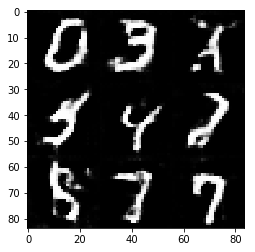

Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 0.7099
Epoch 1/2... Discriminator Loss: 1.4201... Generator Loss: 0.3509
Epoch 1/2... Discriminator Loss: 1.0732... Generator Loss: 0.6569
Epoch 2/2... Discriminator Loss: 0.9623... Generator Loss: 0.7392
Epoch 2/2... Discriminator Loss: 0.9854... Generator Loss: 0.8335
Epoch 2/2... Discriminator Loss: 0.9666... Generator Loss: 0.6839
Epoch 2/2... Discriminator Loss: 1.1892... Generator Loss: 0.5621
Epoch 2/2... Discriminator Loss: 1.1834... Generator Loss: 0.5415
Epoch 2/2... Discriminator Loss: 1.3965... Generator Loss: 1.8894
Epoch 2/2... Discriminator Loss: 0.9249... Generator Loss: 1.3304


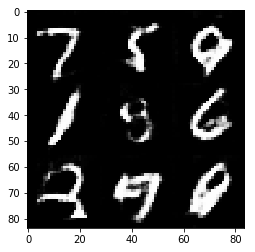

Epoch 2/2... Discriminator Loss: 0.9838... Generator Loss: 1.3245
Epoch 2/2... Discriminator Loss: 0.9899... Generator Loss: 0.9392
Epoch 2/2... Discriminator Loss: 0.9194... Generator Loss: 0.8527
Epoch 2/2... Discriminator Loss: 1.0741... Generator Loss: 0.6271
Epoch 2/2... Discriminator Loss: 1.0899... Generator Loss: 0.8525
Epoch 2/2... Discriminator Loss: 2.5601... Generator Loss: 0.1138
Epoch 2/2... Discriminator Loss: 0.9364... Generator Loss: 0.8220
Epoch 2/2... Discriminator Loss: 1.4825... Generator Loss: 0.3514
Epoch 2/2... Discriminator Loss: 1.0825... Generator Loss: 0.5914
Epoch 2/2... Discriminator Loss: 0.9217... Generator Loss: 1.6790


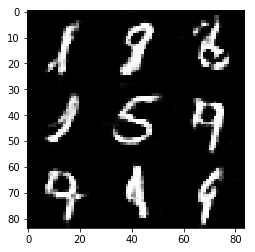

Epoch 2/2... Discriminator Loss: 0.6808... Generator Loss: 1.2844
Epoch 2/2... Discriminator Loss: 1.2365... Generator Loss: 0.5406
Epoch 2/2... Discriminator Loss: 1.3983... Generator Loss: 0.3872
Epoch 2/2... Discriminator Loss: 0.8763... Generator Loss: 0.7738
Epoch 2/2... Discriminator Loss: 0.7984... Generator Loss: 0.9636
Epoch 2/2... Discriminator Loss: 1.5035... Generator Loss: 3.2417
Epoch 2/2... Discriminator Loss: 0.8283... Generator Loss: 0.8537
Epoch 2/2... Discriminator Loss: 1.0999... Generator Loss: 0.6188
Epoch 2/2... Discriminator Loss: 2.1778... Generator Loss: 0.1737
Epoch 2/2... Discriminator Loss: 0.9510... Generator Loss: 0.8328


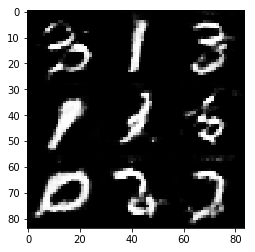

Epoch 2/2... Discriminator Loss: 0.8512... Generator Loss: 1.2821
Epoch 2/2... Discriminator Loss: 0.9848... Generator Loss: 0.8632
Epoch 2/2... Discriminator Loss: 1.0201... Generator Loss: 0.7984
Epoch 2/2... Discriminator Loss: 0.7649... Generator Loss: 1.3699
Epoch 2/2... Discriminator Loss: 0.9351... Generator Loss: 1.0023
Epoch 2/2... Discriminator Loss: 1.0275... Generator Loss: 0.8258
Epoch 2/2... Discriminator Loss: 1.1377... Generator Loss: 0.5620
Epoch 2/2... Discriminator Loss: 1.4002... Generator Loss: 0.4120
Epoch 2/2... Discriminator Loss: 0.7949... Generator Loss: 1.2782
Epoch 2/2... Discriminator Loss: 0.9017... Generator Loss: 1.8418


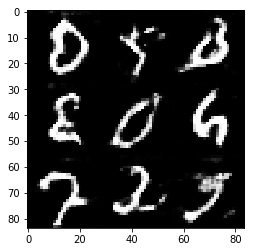

Epoch 2/2... Discriminator Loss: 0.6981... Generator Loss: 0.9910
Epoch 2/2... Discriminator Loss: 2.7637... Generator Loss: 0.0976
Epoch 2/2... Discriminator Loss: 0.8520... Generator Loss: 2.1163
Epoch 2/2... Discriminator Loss: 0.7245... Generator Loss: 1.0135
Epoch 2/2... Discriminator Loss: 1.1216... Generator Loss: 0.5665
Epoch 2/2... Discriminator Loss: 0.8585... Generator Loss: 0.8337
Epoch 2/2... Discriminator Loss: 0.8976... Generator Loss: 1.4817
Epoch 2/2... Discriminator Loss: 0.8231... Generator Loss: 0.8395
Epoch 2/2... Discriminator Loss: 0.6585... Generator Loss: 1.0186
Epoch 2/2... Discriminator Loss: 2.3101... Generator Loss: 3.9341


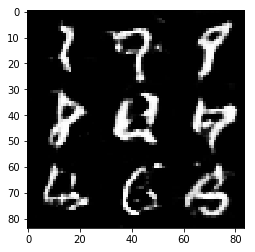

Epoch 2/2... Discriminator Loss: 0.9124... Generator Loss: 0.8626
Epoch 2/2... Discriminator Loss: 0.8943... Generator Loss: 0.8649
Epoch 2/2... Discriminator Loss: 1.0165... Generator Loss: 0.6417
Epoch 2/2... Discriminator Loss: 0.6543... Generator Loss: 1.0249
Epoch 2/2... Discriminator Loss: 0.9173... Generator Loss: 1.9684
Epoch 2/2... Discriminator Loss: 1.4528... Generator Loss: 0.4412
Epoch 2/2... Discriminator Loss: 0.7979... Generator Loss: 0.8850
Epoch 2/2... Discriminator Loss: 0.6737... Generator Loss: 1.1080
Epoch 2/2... Discriminator Loss: 0.9997... Generator Loss: 0.6737
Epoch 2/2... Discriminator Loss: 0.4666... Generator Loss: 1.4070


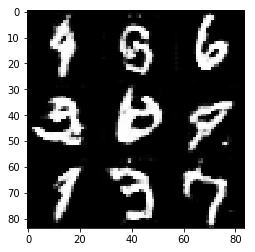

Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 0.5787
Epoch 2/2... Discriminator Loss: 0.5710... Generator Loss: 1.5856
Epoch 2/2... Discriminator Loss: 0.5026... Generator Loss: 1.2018
Epoch 2/2... Discriminator Loss: 0.7890... Generator Loss: 1.0656
Epoch 2/2... Discriminator Loss: 0.6936... Generator Loss: 1.2580
Epoch 2/2... Discriminator Loss: 0.8706... Generator Loss: 1.1261
Epoch 2/2... Discriminator Loss: 1.2493... Generator Loss: 0.5306
Epoch 2/2... Discriminator Loss: 1.1114... Generator Loss: 0.6236
Epoch 2/2... Discriminator Loss: 1.7528... Generator Loss: 0.2985
Epoch 2/2... Discriminator Loss: 0.7406... Generator Loss: 1.7649


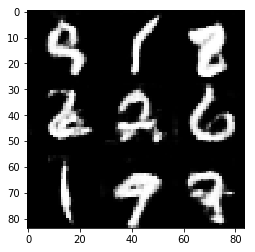

Epoch 2/2... Discriminator Loss: 1.0098... Generator Loss: 0.7589
Epoch 2/2... Discriminator Loss: 1.9440... Generator Loss: 2.7684
Epoch 2/2... Discriminator Loss: 0.9316... Generator Loss: 0.9879
Epoch 2/2... Discriminator Loss: 0.9794... Generator Loss: 0.8736
Epoch 2/2... Discriminator Loss: 0.6654... Generator Loss: 1.1077
Epoch 2/2... Discriminator Loss: 0.9062... Generator Loss: 0.8630
Epoch 2/2... Discriminator Loss: 1.0074... Generator Loss: 0.7024
Epoch 2/2... Discriminator Loss: 0.5510... Generator Loss: 1.3102
Epoch 2/2... Discriminator Loss: 0.5206... Generator Loss: 1.5092
Epoch 2/2... Discriminator Loss: 0.6048... Generator Loss: 1.0377


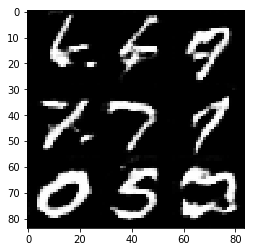

Epoch 2/2... Discriminator Loss: 1.4222... Generator Loss: 0.5287
Epoch 2/2... Discriminator Loss: 1.1612... Generator Loss: 0.5899
Epoch 2/2... Discriminator Loss: 1.0132... Generator Loss: 0.7762
Epoch 2/2... Discriminator Loss: 0.7119... Generator Loss: 1.0284
Epoch 2/2... Discriminator Loss: 0.7241... Generator Loss: 1.0217
Epoch 2/2... Discriminator Loss: 0.5569... Generator Loss: 1.7155
Epoch 2/2... Discriminator Loss: 0.7272... Generator Loss: 1.1481
Epoch 2/2... Discriminator Loss: 1.1309... Generator Loss: 0.6302
Epoch 2/2... Discriminator Loss: 0.5569... Generator Loss: 1.2135
Epoch 2/2... Discriminator Loss: 1.2189... Generator Loss: 0.6762


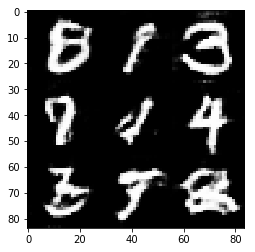

Epoch 2/2... Discriminator Loss: 1.0887... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.0840... Generator Loss: 0.7694
Epoch 2/2... Discriminator Loss: 0.8875... Generator Loss: 0.7677
Epoch 2/2... Discriminator Loss: 1.2734... Generator Loss: 0.4451
Epoch 2/2... Discriminator Loss: 1.0652... Generator Loss: 1.5832
Epoch 2/2... Discriminator Loss: 0.7029... Generator Loss: 1.2676
Epoch 2/2... Discriminator Loss: 0.7118... Generator Loss: 1.1636


In [123]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.